Machine Learning and Pattern Recognition

Image recognition exercise


## Introduction

Write an introductory chapter for your report **(1 p)**
<br>E.g.
- What is the purpose of this task?
- What kind of data were used? Where did it originate?
- Which methods did you use?

Images: https://unsplash.com/

## Data preparation

Perform preparations for the data **(3 p)**
- import all the packages needed for this notebook in one cell
- read the URL:s from the text files and import the images
- crop and/or resize the images into same size
- for GLCM and GLRLM, change the images into grayscale and reduce the quantization level, e.g. to 8 levels

The purpose of this task in general to learn about image classification. It's done by learning how to classify different types of color images by using different supervised machine learning algorithms. 
Used data was given for the task as URLs in a text file from unsplash.com. The data consisted of 3 different classes of images. Each image belongs to one class of grass, sand or stairs. Images were in RGB colored and in various different sizes. At first I had to import the images and prepare them for the classifiers. 
Method used for classification are k nearest neighbors algorithm, regualirized linear model and Multi-layer perceptron. Classifiers performance are estimated and compared.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from skimage.transform import resize
from skimage import color
from skimage import img_as_ubyte
from skimage.feature import greycomatrix
from skimage.feature import greycoprops
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier

In [2]:
# read URLSs from txt files

grass_images=[]
urls_grass=np.loadtxt('grass.txt', dtype='U150')

sand_images=[]
urls_sand=np.loadtxt('sand.txt', dtype='U150')

stairs_images=[]
urls_stairs=np.loadtxt('stairs.txt', dtype='U150')

# grass: iterate for each row(image url) and import image to list
for i in range(len(urls_grass)):
    
    url=urls_grass[i]
    url = url[2:]
    img=io.imread(url)
    
    # Resize each image into same size (100x100 pixels)
    img = resize(img,(100,100), mode='constant', anti_aliasing=True, anti_aliasing_sigma=None)
    grass_images.append(img)
    
# sand: iterate for each row(image url) and import image to list
for i in range(len(urls_sand)):
    
    url=urls_sand[i]
    url = url[2:]
    img=io.imread(url)
    
    # Resize each image into same size (100x100 pixels)
    img = resize(img,(100,100), mode='constant', anti_aliasing=True, anti_aliasing_sigma=None)
    sand_images.append(img) 
    
# stairs: iterate for each row(image url) and import image to list
for i in range(len(urls_stairs)):
    
    url=urls_stairs[i]
    url = url[2:]
    img=io.imread(url)
    
    # Resize each image into same size (100x100 pixels)
    img = resize(img,(100,100), mode='constant', anti_aliasing=True, anti_aliasing_sigma=None)
    stairs_images.append(img)


In [3]:
#Grayscale image lists
grass_gray=[]
sand_gray=[]
stairs_gray=[]

# repeat for each grass image
for i in range(len(grass_images)):
    
    #change from rgb to grayscale
    img_gray = color.rgb2gray(grass_images[i])
    
    #reduce quantization level to 8
    img_gray8 = np.uint8(img_gray*255)
    img_gray8 = np.round(img_gray8/36)
    img_gray8 = img_gray8.astype(np.uint8)
    
    #add grayscale images to separate list
    grass_gray.append(img_gray8)
    
for i in range(len(sand_images)):
    
    #change from rgb to grayscale
    img_gray = color.rgb2gray(sand_images[i])
    
    #reduce quantization level to 8
    img_gray8 = np.uint8(img_gray*255)
    img_gray8 = np.round(img_gray8/36)
    img_gray8 = img_gray8.astype(np.uint8)
    
    #add grayscale images to separate list
    sand_gray.append(img_gray8)
    
for i in range(len(stairs_images)):
    
    #change from rgb to grayscale
    img_gray = color.rgb2gray(stairs_images[i])
    
    #reduce quantization level to 8
    img_gray8 = np.uint8(img_gray*255)
    img_gray8 = np.round(img_gray8/36)
    img_gray8 = img_gray8.astype(np.uint8)
    
    #add grayscale images to separate list
    stairs_gray.append(img_gray8)


## Feature extraction

### First order texture measures (6 features)

- Calculate the below mentioned color features for each image **(1 p)**
    - Mean for each RGB color channel
    - Variance for each RGB color channel

In [4]:
RGB_mean_grass=[]
RGB_var_grass=[]
RGB_mean_sand=[]
RGB_var_sand=[]
RGB_mean_stairs=[]
RGB_var_stairs=[]

#calculating mean and variance for each RGB color channel for each image
for i in range(len(grass_images)):
    img = grass_images[i]
    
    mean = np.mean(img, axis=(0,1))
    RGB_mean_grass.append(mean)
    
    variance = np.var(img,axis=(0,1))
    RGB_var_grass.append(variance)    


for i in range(len(sand_images)):
    img = sand_images[i]
    
    mean = np.mean(img, axis=(0,1))
    RGB_mean_sand.append(mean)
    
    variance = np.var(img,axis=(0,1))
    RGB_var_sand.append(variance)

for i in range(len(stairs_images)):
    img = stairs_images[i]
    
    mean = np.mean(img, axis=(0,1))
    RGB_mean_stairs.append(mean)
    
    variance = np.var(img,axis=(0,1))
    RGB_var_stairs.append(variance)   
    


### Second order texture measures (4 or 10 features)

- Gray-Level-Co-Occurrence (GLCM) features (4 features) **(2 p)**
    - For each image
        - calculate the GLC matrix
        - calculate the "correlation" feature using the GLC matrix that you acquired 
            - in horizontal and vertical directions for two reference pixel distances (you can choose the distances)
        - explain your choise for the distances<br>
<br>
- Gray-Level-Run-Length (GLRL) features (6 features) **(BONUS)**
    - Make an own implementation for Gray-Level-Run-Length (GLRL) matrix in
        - horizontal direction
        - vertical direction
        - test that your code works with the toy image: [[1,1,1,0],[2,0,0,1],[1,0,2,2],[0,0,0,0]]
    - Implement the following run-length features using the GLRL matrix that you acquired
        - Short-Run emphasis
        - Long-run emphasis
        - Run percentage
    - Include the resulting features in the input array X

In [5]:
# Gray-Level-Co-Occurrence (GLCM) features (4 features)
grass_correlation=[]
grass_output=[]

sand_correlation=[]
sand_output=[]

stairs_correlation=[]
stairs_output=[]


#Grass images
for i in range(len(grass_gray)):
    
    #calculating GLC matrix using two distances and angles
    glcm = greycomatrix(grass_gray[i], distances=[1, 10], angles=[0, np.pi/2], levels=8, symmetric=True, normed=True)
    
    #calculating correlation feature using GLCM
    correlation = greycoprops(glcm, 'correlation')
    
    #store correlation features to list
    grass_correlation.append(correlation)
    
    #generating grass output array
    grass_output.append('grass')

# Sand images    
for i in range(len(sand_gray)):
    
    #calculating GLC matrix using two distances and angles
    glcm = greycomatrix(sand_gray[i], distances=[1, 10], angles=[0, np.pi/2], levels=8, symmetric=True, normed=True)
    
    #calculating correlation feature using GLCM
    correlation = greycoprops(glcm, 'correlation')
    
    #store correlation features to list
    sand_correlation.append(correlation)
    
    #generating sand output array
    sand_output.append('sand')
# Stairs images
for i in range(len(stairs_gray)):
    
    #calculating GLC matrix using two distances and angles
    glcm = greycomatrix(stairs_gray[i], distances=[1, 10], angles=[0, np.pi/2], levels=8, symmetric=True, normed=True)
    
    #calculating correlation feature using GLCM
    correlation = greycoprops(glcm, 'correlation')
    
    #store correlation features to list
    stairs_correlation.append(correlation)
    
    #generating stairs output array
    stairs_output.append('stairs')    


Gather your features into an input array X, and the image classes into an output array y. Standardize the feature values in X.

Make illustrations of the feature relationships, and discuss the results

### Pairplot

- Pairplot **(1 p)**
    - Which feature pairs possess roughly linear dependence?

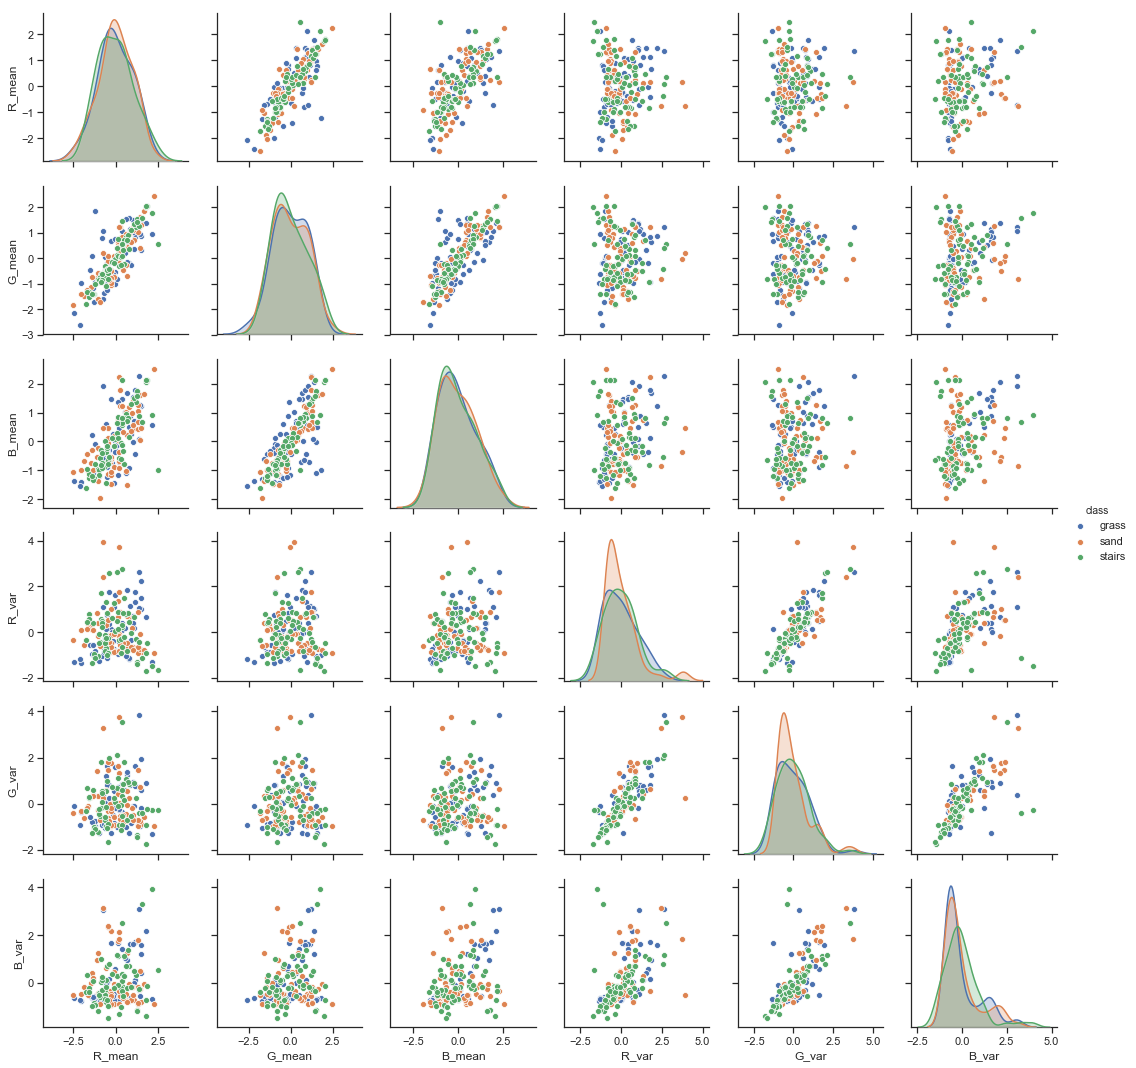

In [6]:
# GRASS: convert to pandas dataframes
RGB_mean_grass_df = pd.DataFrame(RGB_mean_grass)
RGB_var_grass_df=pd.DataFrame(RGB_var_grass)
grass_out_df = pd.DataFrame(grass_output)

#combine mean and variance
RGB_grass_features = pd.DataFrame(np.concatenate((RGB_mean_grass_df, RGB_var_grass_df), axis=1))

#stantardize features
RGB_grass_features = StandardScaler().fit_transform(RGB_grass_features)

#SAND: convert to pandas dataframes
RGB_mean_sand_df = pd.DataFrame(RGB_mean_sand)
RGB_var_sand_df=pd.DataFrame(RGB_var_sand)
sand_out_df = pd.DataFrame(sand_output)

#combine mean and variance
RGB_sand_features = pd.DataFrame(np.concatenate((RGB_mean_sand_df, RGB_var_sand_df), axis=1))

#stantardize features
RGB_sand_features = StandardScaler().fit_transform(RGB_sand_features)

#STAIRS: convert to pandas dataframes
RGB_mean_stairs_df = pd.DataFrame(RGB_mean_stairs)
RGB_var_stairs_df=pd.DataFrame(RGB_var_stairs)
stairs_out_df = pd.DataFrame(stairs_output)

#combine mean and variance
RGB_stairs_features = pd.DataFrame(np.concatenate((RGB_mean_stairs_df, RGB_var_stairs_df), axis=1))

#stantardize features
RGB_stairs_features = StandardScaler().fit_transform(RGB_stairs_features)



#combine input and output arrays (features with image classes)
RGB_grass_features2= pd.DataFrame(np.concatenate((RGB_grass_features, grass_out_df), axis=1))
RGB_sand_features2= pd.DataFrame(np.concatenate((RGB_sand_features, sand_out_df), axis=1))
RGB_stairs_features2= pd.DataFrame(np.concatenate((RGB_stairs_features, stairs_out_df), axis=1))

#combine all image classes into one dataframe
RGB_features= pd.DataFrame(np.concatenate((RGB_grass_features2, RGB_sand_features2, RGB_stairs_features2), axis=0))
RGB_features = RGB_features.rename(columns={0: 'R_mean', 1: 'G_mean', 2: 'B_mean', 3: 'R_var', 4:'G_var',5:'B_var',6:'class'})
#print(RGB_features)

#pairplot using seaborn
sns.set(style="ticks", color_codes=True )
g = sns.pairplot(RGB_features, hue="class")


From the results it seems that red mean and green mean values have the most linear depency. Red variance and green variance has also rougly linear depency. I am surpised there not much more clear differences between the image classes. This also made me question if my solution is even correct or if there are some mistakes.

### PCA

- PCA **(1 p)**
    - Can you see any clusters in PCA?
    - Does this figure give you any clues, how well you will be able to classify the image types? Explain.

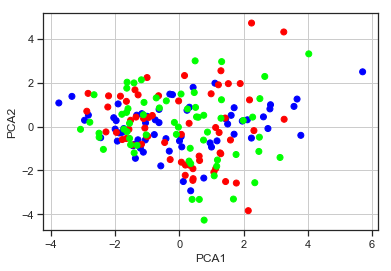

In [7]:
#split features and target values
pca_features = RGB_features.loc[:, ['R_mean','G_mean','B_mean','R_var','G_var','B_var']].values
pca_target = RGB_features.loc[:,['class']].values
pca_target= pd.DataFrame(data=pca_target, columns=['class'])

# PCA using scikit learn
pca = PCA(n_components =2)
pca2= pca.fit_transform(pca_features)

pcaDf = pd.DataFrame(data= pca2, columns = ['PCA1', 'PCA2'])
pca_df = pd.concat([pcaDf, pca_target], axis=1)

# numeric values for color mapping
pca_target['class'] = pca_target['class'].replace({'grass':0, 'sand':1, 'stairs':2})

plt.scatter(pca2[:,0], pca2[:,1], c=pca_target['class'], cmap='brg')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
#plt.legend(pca_target['class'])
plt.grid()

No visible notable clusters to be seen. This should mean that classifying the images based on RGB information is quite difficult.

## Build classifiers and estimate their performance

### kNN

- k Nearest Neighbors classifier **(1 p)**
    - optimize the hyperparameter (k) and select the best model for the classifier
    - estimate the performance of the model with nested cross validation
    - calculate the accuracy and the confusion matrix

In [8]:
# KNN based on the example from the slides (allowed?)

k_range=range(1,31)

loo= LeaveOneOut()

knn=KNeighborsClassifier()

y_preds=[]
best_ks=[]

x = RGB_features.loc[:, ['R_mean','G_mean','B_mean','R_var','G_var','B_var',]].values
y = RGB_features.loc[:,['class']].values

# split to train and test test using leave-one-out cross-validation
for train_index, test_index in loo.split(x):
    
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scores=[]
    #repeat for each k value to find the best one
    for k in k_range:
        
        inner_scores=[]
        #split trainin set again (nested cross-validation)
        for subtrain_index, subtest_index in loo.split(x_train):
            
            x_subtrain, x_subtest = x_train[subtrain_index], x_train[subtest_index]
            y_subtrain, y_subtest = y_train[subtrain_index], y_train[subtest_index]
            
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(x_subtrain, np.ravel(y_subtrain))
            inner_scores.append(knn.score(x_subtest, y_subtest))                                                            
        
                                
        scores.append(np.mean(inner_scores))                                     
    # find best k                           
    best_ks.append(k_range[scores.index(max(scores))])
    
    # train model with the best k value
    knn=KNeighborsClassifier(n_neighbors=best_ks[test_index[0]])
    knn.fit(x_train, np.ravel(y_train))
    
    y_preds.append(knn.predict(x_test))
        


In [9]:
print('Predicted:','grass', 'sand', 'stairs')
print('True: grass',confusion_matrix(y,y_preds)[0])
print('True: sand',confusion_matrix(y,y_preds)[1])
print('True: stairs',confusion_matrix(y,y_preds)[2])
print(np.round(accuracy_score(y,y_preds),3))

print('Best k and counts:')
for best_k in np.unique(best_ks):
    print(best_k, ':', best_ks.count(best_k))

Predicted: grass sand stairs
True: grass [39 11 12]
True: sand [ 6 39 16]
True: stairs [11 25 26]
0.562
Best k and counts:
1 : 8
4 : 177


### Ridge regression

- Regularized linear model with Ridge regression **(1 p)**
    - optimize the hyperparameter (alpha) and select the best model for the classifier
    - estimate the performance of the model with nested cross validation
    - calculate the accuracy and the confusion matrix

In [10]:
#alpha_range= np.arange(0.0, 1, 0.1)
#print(k_range[1])

alpha_range=range(1,10)
loo= LeaveOneOut()


y_preds=[]
best_ks=[]

x = RGB_features.loc[:, ['R_mean','G_mean','B_mean','R_var','G_var','B_var',]].values
y = RGB_features.loc[:,['class']].values


for train_index, test_index in loo.split(x):
    
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    scores=[]
    
    for k in alpha_range:
        
        inner_scores=[]
        
        
        
        for subtrain_index, subtest_index in loo.split(x_train):
            
            x_subtrain, x_subtest = x_train[subtrain_index], x_train[subtest_index]
            y_subtrain, y_subtest = y_train[subtrain_index], y_train[subtest_index]
            
            clf = RidgeClassifier(alpha=k)
            clf.fit(x_subtrain, np.ravel(y_subtrain))
            inner_scores.append(clf.score(x_subtest, y_subtest))                                                            
        
                                
        scores.append(np.mean(inner_scores))                                     
                                
    best_ks.append(k_range[scores.index(max(scores))])
    
    clf=RidgeClassifier(alpha=best_ks[test_index[0]])
    clf.fit(x_train, np.ravel(y_train))
    
    y_preds.append(clf.predict(x_test))
        

In [11]:
#print(y_preds)
print(k_range)
#print(k_range[2])
#y_preds_l= np.array(y_preds)
#flattened = [val for sublist in y_preds_l for val in sublist]
#y_preds=np.round(y_preds)
#print(np.array(flattened))

print('Predicted:','grass', 'sand', 'stairs')
print('True: grass',confusion_matrix(y, y_preds)[0])
print('True: sand',confusion_matrix(y,y_preds)[1])
print('True: stairs',confusion_matrix(y,y_preds)[2])
print('accuracy:', np.round(accuracy_score(y,y_preds),3))

print('Best k and counts:')
for best_k in np.unique(best_ks):
    print(best_k, ':', best_ks.count(best_k))
    
    


range(1, 31)
Predicted: grass sand stairs
True: grass [ 0  0 62]
True: sand [35  0 26]
True: stairs [62  0  0]
accuracy: 0.0
Best k and counts:
1 : 185


 ### Multi-layer perceptron


- Multi-layer perceptron MLP **(2 p)**
    - build the classifier. Use:
        - 1 hidden layer
        - solver for weight optimization: stochastic gradient-based optimizer ('adam')
        - activation function for the hidden layer: rectified linear unit function ('relu')
        - Early stop
    - optimize the number of neurons in the hidden layer and select the best model for the classifier
    - use Early stop committee, i.e. after selecting the model, calculate the prediction for the test data several times with different sampling of the training data. The members of the committee vote for the predicted class of the test sample. Use 50% of the training data for validation (algorithm terminates the training when validation score is not improving)
    - estimate the performance of the classifier with nested cross validation
    - calculate the accuracy and the confusion matrix


## Discussion

- Discuss you results **(1 p)**
<br>E.g.
    - Which model performs the best and why?
    - What are the limitations?
    - How could the results be improved?

From my lacking solutions (no MLP) the knn model performed the best, even though it had poor accuracy of 0.562. 
KNN only used the mean color values of the pictures, so when the colors were not that distinct from each other, the results are limited. I also resized the pictures to 100x100 pixels to minimize performance issue. This resizing causes some information loss of the image colors. At first I tried using 1000x10000 pixels, but it seemed the results were quite similar to using smalles images. Using the most accurate images should improve the results though.
I was unable to get any positive accuration using ridge regression classification, which only resulted in 0. 
I reckon using MLP would lead to the best results, but I was unable to try to solve it because of my poor scheduling of the task.